<a href="https://colab.research.google.com/github/alyilmaz99/language-detection/blob/main/modeldet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# kütüphaneler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# BERT modelini yükleme
model_name = 'dbmdz/bert-base-turkish-128k-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Veri setini yükleme (örnek olarak bir dil veri seti kullanıldı)
data = pd.read_csv('/content/LanguageDetection.csv')
#Tekrarlı veri kontrolu
data.duplicated().sum()
#Tekrarlı veriyi silme
data.drop_duplicates(inplace= True)
print(data)

                                                    Text Language
0       Nature, in the broadest sense, is the natural...  English
1      "Nature" can refer to the phenomena of the phy...  English
2      The study of nature is a large, if not the onl...  English
3      Although humans are part of nature, human acti...  English
4      [1] The word nature is borrowed from the Old F...  English
...                                                  ...      ...
10332  ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...  Kannada
10333  ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...  Kannada
10334  ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...  Kannada
10335  ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...  Kannada
10336  ಟೆರ್ರಿ ನೀವು ನಿಜವಾಗಿಯೂ ಆ ದೇವದೂತನಂತೆ ಸ್ವಲ್ಪ ಕಾಣು...  Kannada

[10271 rows x 2 columns]


In [4]:
# Veri setini train ve test setlerine ayırma
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# LabelEncoder oluşturma
label_encoder = LabelEncoder()

# Eğitim verileri için Language sütununu dönüştürme
train_labels_encoded = label_encoder.fit_transform(train_data['Language'])

# Test verileri için Language sütununu dönüştürme
test_labels_encoded = label_encoder.transform(test_data['Language'])

# Eğitim etiketlerini one-hot encoding yapma
train_labels = to_categorical(train_labels_encoded, num_classes=len(label_encoder.classes_))

# Test etiketlerini one-hot encoding yapma
test_labels = to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))


In [5]:
# Veri setini BERT için uygun formata dönüştürme
def convert_to_input(data):
    encodings = tokenizer(
        data['Text'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    return encodings

train_encodings = convert_to_input(train_data)
test_encodings = convert_to_input(test_data)

# BERT modelini ince ayarlama için özelleştirme
input_layer = Input(shape=(128,), dtype='int32')
bert_output = bert_model(input_layer)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(bert_output.logits)
model = Model(inputs=input_layer, outputs=output_layer)

In [6]:
# Modeli derleme
optimizer = Adam(learning_rate=0.0001)  # Öğrenme oranını düşürme
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Modeli eğitme
history = model.fit(
    x=train_encodings['input_ids'],
    y=train_labels,
    validation_data=(test_encodings['input_ids'], test_labels),
    epochs=15,  # Daha fazla epoch eğitmeyi deneyebilirsiniz
    batch_size=32
)

Epoch 1/15
257/257 [==============================] - 105s 254ms/step - loss: 2.8151 - accuracy: 0.0648 - val_loss: 2.8284 - val_accuracy: 0.0730
Epoch 2/15
257/257 [==============================] - 59s 231ms/step - loss: 2.8275 - accuracy: 0.0680 - val_loss: 2.8176 - val_accuracy: 0.0730
Epoch 3/15
257/257 [==============================] - 58s 226ms/step - loss: 2.8216 - accuracy: 0.0724 - val_loss: 2.8108 - val_accuracy: 0.0730
Epoch 4/15
257/257 [==============================] - 58s 224ms/step - loss: 2.8150 - accuracy: 0.0708 - val_loss: 2.8057 - val_accuracy: 0.1022
Epoch 5/15
257/257 [==============================] - 57s 223ms/step - loss: 2.8082 - accuracy: 0.0693 - val_loss: 2.7936 - val_accuracy: 0.0730
Epoch 6/15
257/257 [==============================] - 57s 223ms/step - loss: 2.8011 - accuracy: 0.0717 - val_loss: 2.7841 - val_accuracy: 0.0730
Epoch 7/15
257/257 [==============================] - 57s 223ms/step - loss: 2.7964 - accuracy: 0.0719 - val_loss: 2.7779 - val_a

In [8]:
# Modeli kaydetme
model.save('/content/language_detector.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


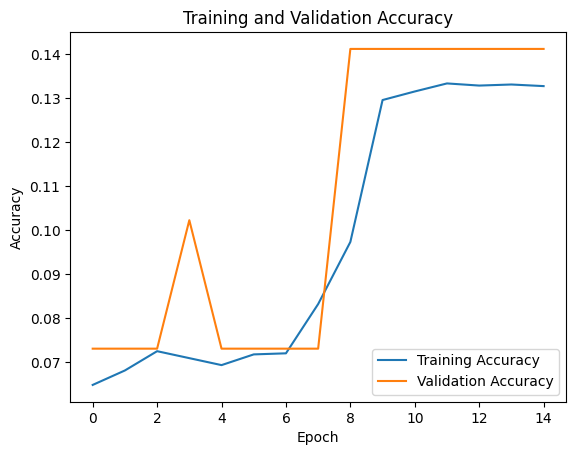

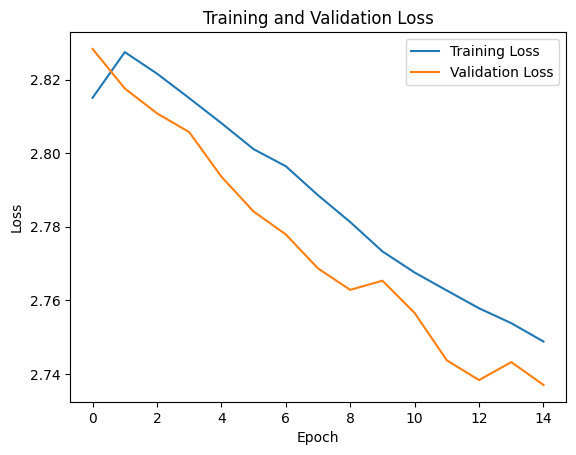

In [9]:
# Eğitim sürecinin doğruluk (accuracy) ve kayıp (loss) grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Tahminler yapma
predictions = model.predict(test_encodings['input_ids'])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

65/65 [==============================] - 8s 73ms/step


In [11]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   0   0 121   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  85   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 108   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 290   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 210   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  86   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  65   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 130   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  70   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 139   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 119   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 160   0   0   0   0   0   0   0   0   0   0  

In [12]:
# Classification report
class_report = classification_report(true_classes, predicted_classes)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.00      0.00      0.00        85
           2       0.00      0.00      0.00       108
           3       0.14      1.00      0.25       290
           4       0.00      0.00      0.00       210
           5       0.00      0.00      0.00        86
           6       0.00      0.00      0.00        65
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00       130
           9       0.00      0.00      0.00        70
          10       0.00      0.00      0.00       122
          11       0.00      0.00      0.00       139
          12       0.00      0.00      0.00       119
          13       0.00      0.00      0.00       160
          14       0.00      0.00      0.00       150
          15       0.00      0.00      0.00        86
          16       0.00      0.00      0.00       106

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
